## 1. 设计个小游戏

### 1.1 游戏本身的建模

- 游戏建模在 `2d` 空间
- 8 个向量达标1个 8 边形 表示一个 **小行星**


In [125]:
import math
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from random import randint, uniform

import pygame

from chapters.internal.tools import vectors
from chapters.internal.tools.draw_2d import *


class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0  # 小行星移动的时候, 这个是旋转角度
        self.x = 0
        self.y = 0

    def transformed_wrong(self):
        """
        这里先平移 .  再旋转，就有问题.
        因此 这里的旋转向量是按照 (0,0) 旋转的
        """

        moved_v = [vectors.add((self.x, self.y), v) for v in points]
        rotated = [
            vectors.rotate2d(self.rotation_angle, v)
            for v in moved_v]
        return rotated

    def transformed(self):
        """
        这个方法由 x, y 属性转换 旋转的点 .

        关键是
        1. 先旋转
        2. 再平移
        """
        rotated = [
            vectors.rotate2d(self.rotation_angle, v)
            for v in self.points]
        return [vectors.add((self.x, self.y), v) for v in rotated]


class Ship(PolygonModel):
    """
    飞船是一个三角形
    """

    def __init__(self):
        super().__init__(
            [
                (0.5, 0),
                (-0.25, 0.25),
                (-0.25, -0.25)
            ],
        )


class Asteroid(PolygonModel):
    def __init__(self):
        # 小行星的边是随机的
        sides = randint(5, 9)
        vs = [vectors.to_cartesian(
            (
                # 随机长度是 0.5 -> 1.0
                uniform(0.5, 1.0),
                # 角度绕 360 度, 这样刚好能组成1个多边形
                math.pi * 2 * (i / sides)
            )
        ) for i in range(0, sides)]

        super().__init__(vs)




我们先测试一下画个 小行星 .

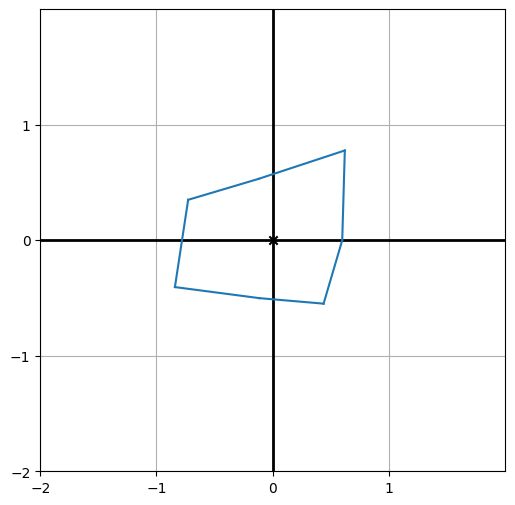

In [126]:
points = Asteroid().points
draw2d(Polygon(*points))

再测试画个小飞船

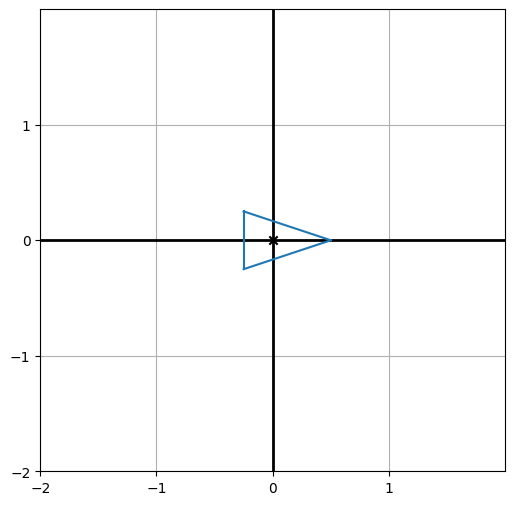

In [127]:
points = Ship().points
draw2d(Polygon(*points))

### 1.1.2 游戏的基本渲染

游戏的初始化状态:

1. 1个 `ship` : 被固定在中心位置
2. 几个 `asteroid` : 随机分布在屏幕上

In [128]:
ship = Ship()

# 1. 创建 一个 小行星列表
asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

# 2. 把他们随机安排在各种位置上
for ast in asteroids:
    ast.x = randint(-9, 9)
    ast.y = randint(-9, 9)

我们打算用  **PyGame** 内置的坐标系来 渲染. 他是一个 400*400 像素的屏幕 .

- PyGame 的坐标系不仅仅更大, 而且被倒置了 .
- 因此. 我们需要先写一个 函数在进行 坐标系的转换.

In [129]:
from chapters.c7.asteroid import main

# 这个是绿色 保护着你
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

width, height = 400, 400


def to_pixels(x, y):
    """
    转换为 PyGames 的坐标系
    """
    return width / 2 + width * x / 20, height / 2 - height * y - 20


v1 = (-9, 9)  # 转换的结果是 (20.0, -3420.0) .怪怪的 .


def draw_poly(screen, polygon_model, color=GREEN):
    pixel_points = [to_pixels(x, y) for x, y in polygon_model.transformed()]
    pygame.draw.aalines(screen, color, True, pixel_points, 10)


def draw_segment(screen, v1, v2, color=RED):
    pygame.draw.aaline(screen, color, to_pixels(*v1), to_pixels(*v2), 10)



由于 notebook 表示动画的能力有限, 我们放到 专门的代码中

In [130]:
# 打开下面的注释可以看见效果
# main()

### 1.3 实现激光


激光从 `ship` 的头部发出, 到达边界. 假设激光能 一直杀过去的话.

In [131]:
from math import cos, sin


class Ship(PolygonModel):
    def __init__(self):
        super().__init__([(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)])

    def laser_segment(self):
        """
        返回2个向量 代表从 ship 的x,y 出发按照角度一直到边界
        """
        dist = 20. * sqrt(2)  # 长度.
        x, y = self.transformed()[0]
        return (x, y), (x + dist * cos(self.rotation_angle), y + dist * sin(self.rotation_angle))


ship = Ship()
print(ship.laser_segment())

((0.5, 0.0), (28.784271247461902, 0.0))


### 1.4 测试


**exec1** : 我们来测试旋转平移 `ship` 的测试 .

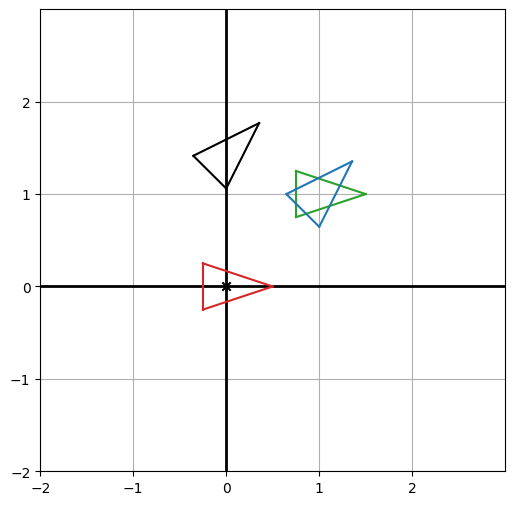

In [132]:
ship = Ship()

ship.x = 1.0
ship.y = 1.0


def ship_2_polygon(s, color=red):
    moved_points = [(p[0] + s.x, p[1] + s.y) for p in s.points]
    return Polygon(*moved_points, color=color)


ship.rotation_angle = math.pi / 4

draw2d(
    Polygon(*ship.points, color=red),
    ship_2_polygon(ship, color=green),
    Polygon(*ship.transformed(), color=blue),
    Polygon(*ship.transformed_wrong(), color=black),
)

- 红色的是原始的
- 绿色的是平移后的
- 蓝色的是正确的
- 黑色是因为先 平移, 再旋转, 所以错了. 旋转是以原点为中心 旋转的. 所以一定要先 **平移**

## 2. 直线的交点计算

### 2.1 为直线选择正确的公式

通用的直线公式 .

$$
给定 \vec{u} 和 \vec{v} . 变量是 t

则通用的公式是:

\vec{u} + \vec{v} \times t

下面用代码表示:

\vec{u} = (2, 3)
\vec{v} = (2, -1)
$$

假设对于任何的 t.

$$
x = 2 \times t + 2
$$

$$
y = -1 \times t + 3
$$

因此 .

$$
2y + x = (-2t + 6) + 2t + 2 = 8
$$

因此

$$
y = (8 - x) \div 2
$$


我们的表达方式 和 函数不同

$$
\vec{r} t = \vec{u} + t \cdot \vec{v}
$$

特别的, 任何的直接可以用如下的 函数表示:

$$
ax + by = c
$$

下面的目标是通过 (x1, y1) 和 (x2, y2) . 2点确定1条直线 .

### 2.2 numpy 提供了求解线性方程组的基本库

我们知道 行求秩法是可以做的 .

In [133]:
import numpy as np

# m1 是1 个用 tuple 表示的矩阵
m1 = (
    (1, -1),
    (1, 2)
)
matrix = np.array(
    m1
)

# 输出是一个数组 .
output = np.array(
    (0, 8)
)

solve = np.linalg.solve(matrix, output)  # 线性方程组求解 .
print(solve)

[2.66666667 2.66666667]


使用库的时候可能有 2个问题:

1. 方程组可能无解 . 2条平行的线永远不可能有交点 ;
2. 可能无解. 同1条直线上的 可能有不同的 函数表达形式 ;
    - 这种矩阵称为 奇异矩阵 ;

我们的目的, 也就是把 2个向量转换为 `numpy` 能计算的形式 .

假设我们知道有如下的2个向量 .

$$
\vec{v_1} 和 \vec{v_2}
$$

$$
\vec{v_1} = (x_1, y_1)
;
\vec{v_2} = (x_2, y_2)
$$




利用代数. 我们开始证明 . 搞出目标格式

$$
ax + by = c
$$

对任意的 x, y, 满足如下条件

$$
(y - y_1) / (x - x_1) = (y - y_2) / (x - x_2)
$$

$$
(y-y_1)(x-x_2) = (y-y_2)(x-x_1)
$$

$$
yx - yx_2 - y_1x + y_1x_2 = yx -yx_1 -y_2x +y_2x_1
$$

$$
(y_2-y_1)x + (x_1-x_2)y = y_2x_1 - y_1x_2
$$

根据上面的推论 , 我们很容易写出来代码 .

In [134]:
def standard_form(v1, v2):
    """
    1个函数表达的形式是 ax + by = c .
    我们通过代数的方式计算出来 .
    而这个 算出来的值 刚好能够被 numpy 帮助我们计算 .
    """
    x1, y1 = v1
    x2, y2 = v2
    a = y2 - y1
    b = x1 - x2
    c = x1 * y2 - y1 * x2
    return a, b, c

再利用下 `numpy` 的矩阵运算 就很容易知道直线交点的情况了.

再搞下 简单的工程, 判断下 交点是否在2个 线段中. 即可 .

In [135]:
from chapters.internal.tools.vectors import distance


def intersection(u1, u2, v1, v2):
    """
    u1, u2 决定了1条直线
    v1 ,v2 决定了另外1条
    通过矩阵运算
    """
    a1, b1, c1 = standard_form(u1, u2)
    a2, b2, c2 = standard_form(v1, v2)
    m = np.array(((a1, b1), (a2, b2)))
    c = np.array((c1, c2))
    return np.linalg.solve(m, c)



def do_segments_intersect(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    try:
        x, y = intersection(u1, u2, v1, v2)
        # 判断是否在 交点是否在 线段内部
        return (distance(u1, (x, y)) <= d1 and
                distance(u2, (x, y)) <= d1 and
                distance(v1, (x, y)) <= d2 and
                distance(v2, (x, y)) <= d2)
    except np.linalg.linalg.LinAlgError:
        return False